This notebook accompanies the following paper : FRION, Anthony et al. Neural Koopman prior for data assimilation. IEEE Transations on Signal Processing. arXiv:2309.05317, 2023.

It enables to reproduce the forecasting results on Sentinel-2 time series that are presented in the paper.

We recommend loading the trained models from the Github repository for direct evaluation. In addition, we provide code for re-training the exact same models, but this requires several hours of training on a GPU.

# Imports

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
    """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (torch.Tensor): Input data.
        x_hat (torch.Tensor): Reconstructed data.

    Returns:
        torch.Tensor: Mean squared error loss.
    """
    total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
    return total_prediction_loss

cuda:0
Tesla T4


In [2]:
!git clone https://github.com/anthony-frion/Sentinel2TS

fatal: destination path 'Sentinel2TS' already exists and is not an empty directory.


# Import data with gdown

Running the cell below enables you to download the Sentinel-2 data directly from Google Drive. Another option is to download the files from https://drive.google.com/drive/u/1/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH and then use it as will, either locally or on a Google Colab session.

In [3]:
# Fontainebleau interpolated time series
!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

# Orléans irregular time series and its mask
!gdown 1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710 -O Orléans_irregular.npy
!gdown 17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF -O Orléans_mask.npy

Downloading...
From (original): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo
From (redirected): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo&confirm=t&uuid=54d4a5e4-723d-4367-a450-1b2d28f184b0
To: /content/Fontainebleau_interpolated.npy
100% 3.43G/3.43G [00:15<00:00, 218MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710
From (redirected): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710&confirm=t&uuid=aff42cb4-daa4-44b6-b158-bc6abb169c3b
To: /content/Orléans_irregular.npy
100% 3.43G/3.43G [00:19<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?id=17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF
To: /content/Orléans_mask.npy
100% 2.87k/2.87k [00:00<00:00, 18.6MB/s]


In [4]:
data = np.load('Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [5]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [6]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [7]:
data_test = np.load('Orléans_irregular.npy')
mask_test = np.load('Orléans_mask.npy')

In [8]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 3:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [9]:
# We extract 150x150 squares out of the 500x500 pixel time series

data_small = data[:,:,250:400,250:400].transpose(0,2,3,1) #150x150
reflectances = data_small.transpose(3,1,2,0)

data_test_small = data_test[:,:,150:300,150:300].transpose(0,2,3,1) #150x150
print(data_test_small.shape)
reflectances_test = data_test_small.transpose(3,1,2,0)

(343, 150, 150, 10)


# Set path for saving models

In [ ]:
# Path for saving the trained models. You can set this path to whatever suitable value.
if os.path.exists('drive/MyDrive'):
  models_path = 'drive/MyDrive'
else:
  models_path = ''
print(f'The path where the models will be saved is {models_path}')

The path where the models will be saved is 


# Data preprocessing

Here, we pre-process the data to a format that is suitable for training the models. We randomly extract slices of length 100 (i.e. one year and a half since one time step is 5 days) corresponding to random pixels and initial times. The RNG seed is manually set so that you can get the same results as in the paper.


In [10]:
time_span = 100
data_small_train = data[:,:,250:400,250:400].transpose(0,2,3,1) #150x150
reflectances = data_small_train.transpose(3,1,2,0)
L = 10
forward = True
batch_size = 512
nb_batches = 512

# We set a manual seed for the RNG so that the results
rng = torch.Generator().manual_seed(42)

initial_times = torch.randint(1, 341 - 2*time_span, (batch_size, nb_batches), generator=rng)

initial_x = torch.randint(0, reflectances.shape[1], (batch_size, nb_batches), generator=rng)
initial_y = torch.randint(0, reflectances.shape[1], (batch_size, nb_batches), generator=rng)

initial_state = torch.Tensor(reflectances[:,initial_x,initial_y,initial_times]).to(device)
initial_state = torch.cat((initial_state,
                            torch.Tensor(reflectances[:,initial_x,initial_y,initial_times]
                                        - reflectances[:,initial_x,initial_y,initial_times-1]).cuda())).T
print(f"Shape of initial_state : {initial_state.shape}")

state_batches = torch.zeros((time_span+1, nb_batches, batch_size, 20)).to(device)
for t in range(time_span+1) :
  state_batches[t] = torch.cat((torch.Tensor(reflectances[:,initial_x,initial_y,initial_times+t]).cuda(),
                    torch.Tensor(reflectances[:,initial_x,initial_y,initial_times+t]
                                  - reflectances[:,initial_x,initial_y,initial_times+t-1]).cuda())).permute((2,1,0))

print(f"Shape of states : {state_batches.shape}")

<ipython-input-10-81d916bdd626>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  - reflectances[:,initial_x,initial_y,initial_times-1]).cuda())).T


Shape of initial_state : torch.Size([512, 512, 20])
Shape of states : torch.Size([101, 512, 512, 20])


In [11]:
initial_x = torch.randint(0, reflectances.shape[1], (batch_size,), generator=rng)
initial_y = torch.randint(0, reflectances.shape[1], (batch_size,), generator=rng)
initial_time = 341 - time_span
initial_state_val = torch.Tensor(reflectances[:,initial_x,initial_y, initial_time]).to(device)
initial_state_val = torch.cat((initial_state_val,
                            torch.Tensor(reflectances[:,initial_x,initial_y,initial_time]
                                        - reflectances[:,initial_x,initial_y,initial_time-1]).cuda())).T
print(f"Shape of initial_state : {initial_state_val.shape}")

states_val = torch.zeros((time_span+1, batch_size, 20)).to(device)
for t in range(time_span+1) :
  states_val[t] = torch.cat((torch.Tensor(reflectances[:,initial_x,initial_y,initial_time+t]).cuda(),
                    torch.Tensor(reflectances[:,initial_x,initial_y,initial_time+t]
                                  - reflectances[:,initial_x,initial_y,initial_time+t-1]).cuda())).T
print(f"Shape of states : {states_val.shape}")


Shape of initial_state : torch.Size([512, 20])
Shape of states : torch.Size([101, 512, 20])


# LSTM

## LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, future=0, n_steps=1):
        outputs = []
        batch_size = x.size(0)
        seq_len = x.size(1)
        h_t = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        # Iterate through time steps
        for i in range(future):
            out, (h_t, c_t) = self.lstm(x[:,-1:,:], (h_t, c_t))
            out = self.fc(out)
            outputs.append(out)
            x = torch.cat((x, out), dim=1)

        outputs = torch.cat(outputs, dim=1)
        return outputs

LSTM = LSTMModel(20,256,20).to(device)

## LSTM training

Here, training the models from scratch takes a lot of time, so we recommend loading the trained models from the Github repository.

In [ ]:
LSTM = LSTMModel(20,256,20).to(device)

print(f"Number of parameters: {count_parameters(LSTM)}")

Number of parameters: 289812


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  LSTM = LSTMModel(20,256,20).to(device)

  print(f"Training a LSTM initialised with seed {seed}")
  time_span = 100
  criterion = nn.MSELoss()
  #opt = torch.optim.Adam(LSTM.parameters(), lr=5e-3)
  opt = torch.optim.Adam(LSTM.parameters(), lr=2e-3)
  #opt = torch.optim.Adam(LSTM.parameters(), lr=1e-3)

  # Train the model
  starting_point = 0
  num_epochs = 500
  max_patience = 50
  patience = 0
  losses = []
  val_losses = []
  val_losses2 = []
  best_val = 1e15
  best_epoch = 0
  for epoch in range(num_epochs):
    if patience > max_patience:
      print("Stopping the training due to no more improvement")
      break
    epoch_loss = 0
    epoch_val_loss = 0
    LSTM.train()
    for batch in range(initial_state.shape[0]):
      opt.zero_grad()
      inputs = initial_state[batch].to(device)
      targets = state_batches[:,batch].permute((1,0,2))[:,1:].to(device)
      #print(inputs.shape)
      outputs = LSTM(inputs.unsqueeze(1), time_span, 1)
      #print(outputs.shape, targets.shape)
      loss = criterion(outputs, targets)
      loss.backward()
      opt.step()
      epoch_loss += loss.item()
    epoch_loss /= nb_batches
    LSTM.eval()
    inputs = initial_state_val.to(device)
    targets = states_val.permute(1,0,2)[:,1:].to(device)
    outputs = LSTM(inputs.unsqueeze(1), time_span, 1)
    epoch_val_loss = criterion(outputs, targets).item()

    losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    whole_predictions = np.zeros((data_small.shape[0]-102, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions = LSTM(states[starting_point].unsqueeze(1),data_small.shape[0]-102).transpose(0,1)
      whole_predictions[starting_point:, column] = predictions[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()
    val_loss2 = np.mean((data_small[starting_point+2:-100,::10] - whole_predictions)[starting_point:] **2)
    val_losses2.append(val_loss2.item())
    print(f"Epoch {epoch+1}: training loss {epoch_loss}, validation loss {epoch_val_loss}")
    print(f"Complete prediction MSE: {val_losses2[-1]}")
    if val_losses2[-1] < best_val:
      print("Saving parameters.")
      best_epoch = epoch
      best_val = val_losses2[-1]
      torch.save(LSTM.state_dict(), f'{models_path}/best_LSTM_{seed}.pt')
      patience = 0
    else:
      patience += 1

## Evaluation on Fontainebleau

In [ ]:
data_small = data_small[:,:100,:100] # use the 100x100 square to match the spatial assimilation data
print(data_small.shape)

(343, 100, 100, 10)


In [ ]:
# Load the models from the Github repository
trained_models_path = 'Sentinel2TS/Benchmark/LSTM/'

In [ ]:
# Load the parameters of one of the trained models
path = trained_models_path + 'best_LSTM_0.pt'
LSTM.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# Compute predictions for the whole 100x100 area from time 1, column by column
initial_time = 1
time_span = 342 - initial_time
predictions = torch.zeros(time_span,data_small.shape[1],data_small.shape[2],20, device='cpu')

for batch in range(data_small.shape[1]) :
  LSTM.eval()
  input = torch.zeros(data_small.shape[2],20).to(device)
  input[:, :10] = torch.tensor(data_small[initial_time,batch,:,:], device=device)
  input[:, 10:] = torch.tensor(data_small[initial_time,batch,:,:]
                              -data_small[initial_time-1,batch,:,:], device=device)

  prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
  predictions[:,batch,:,:] = prediction.permute((1,0,2))

In [ ]:
# Compute the mean squared errors.
# The MSE on training period is far lower than the one on test period
# The resuls reported in the paper are always the MSE on the test period,
# which corresponds to a time period that is absent of the training set.
print(data_small.shape, predictions.shape)
MSE = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10]) **2)
MSE_intra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100] **2)
MSE_extra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:] **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on test period : {MSE_extra}")

(343, 100, 100, 10) torch.Size([341, 100, 100, 20])
Global MSE : 0.0012263121316209435
MSE on training period : 0.0007847055094316602
MSE on test period : 0.0022905836813151836


Band 8


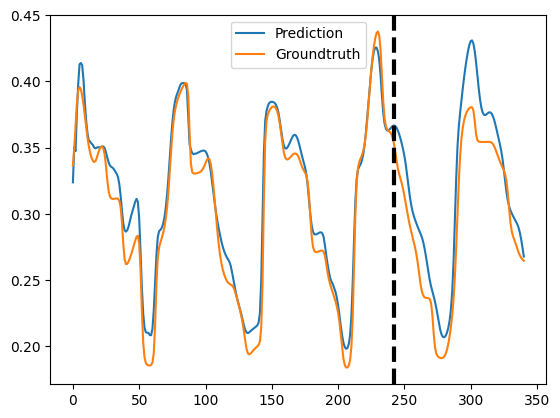

In [ ]:
# Plot the predictions for a random pixel, in order to get a sense of what the model is doing.
# The vertical dashed line marks the limit between the training period and the test period.
# One clearly sees that this model overfits on the training data.
random_pixel = (rd.randint(0,predictions.shape[1]-1), rd.randint(0,predictions.shape[1]-1))
band = 6
band = rd.randint(0,9)
print(f"Band {band}")

plt.plot(predictions[:,random_pixel[0],random_pixel[1],band], label='Prediction')
plt.plot(data_small[initial_time+1:,random_pixel[0],random_pixel[1],band], label='Groundtruth')
plt.axvline([242], 0, 1, c='black', linestyle='dashed', linewidth=3)
plt.legend()

In [ ]:
nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed {seed}")
  LSTM.load_state_dict(torch.load(trained_models_path+f'best_LSTM_{seed}.pt'))
  initial_time = 1
  #initial_time = 242
  time_span = 342 - initial_time
  print(data_small.shape)
  predictions = torch.zeros(time_span,data_small.shape[1],data_small.shape[2],20, device='cpu')
  print(predictions.shape)

  #input = torch.zeros(2048,20).to(device)
  for batch in range(data_small.shape[1]) :
    LSTM.eval()
    #print(batch)
    input = torch.zeros(data_small.shape[2],20).to(device)
    #print(input.shape)
    input[:, :10] = torch.tensor(data_small[initial_time,batch,:,:], device=device)
    input[:, 10:] = torch.tensor(data_small[initial_time,batch,:,:]
                                -data_small[initial_time-1,batch,:,:], device=device)

    prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
    #print(prediction.shape)
    predictions[:,batch,:,:] = prediction.permute((1,0,2))
  MSE = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10]) **2)
  MSE_intra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100] **2)
  MSE_extra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:] **2)
  print(f"Global MSE : {MSE}")
  print(f"MSE on training period : {MSE_intra}")
  print(f"MSE on validation period : {MSE_extra}")
  MSE_list[seed] = MSE_extra
print(f"Mean and standard deviation of the extrapolation error over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed 0
(343, 100, 100, 10)
torch.Size([341, 100, 100, 20])
Global MSE : 0.0012263121316209435
MSE on training period : 0.0007847055094316602
MSE on validation period : 0.0022905836813151836
Seed 1
(343, 100, 100, 10)
torch.Size([341, 100, 100, 20])
Global MSE : 0.0011557918041944504
MSE on training period : 0.000769234960898757
MSE on validation period : 0.00208739354275167
Seed 2
(343, 100, 100, 10)
torch.Size([341, 100, 100, 20])
Global MSE : 0.0011135387467220426
MSE on training period : 0.0007477883482351899
MSE on validation period : 0.0019949970301240683
Seed 3
(343, 100, 100, 10)
torch.Size([341, 100, 100, 20])
Global MSE : 0.0011280047474429011
MSE on training period : 0.0007517069461755455
MSE on validation period : 0.0020348827820271254
Seed 4
(343, 100, 100, 10)
torch.Size([341, 100, 100, 20])
Global MSE : 0.0010721103753894567
MSE on training period : 0.000688411295413971
MSE on validation period : 0.001996824983507395
Mean and standard deviation of the extrapolation error 

The result should be 0.00208 +-0.00011, as reported in the pre-print.

## Evaluation on Orléans

In [ ]:
data_test_small = data_test_small[:,:100,:100] # use the 100x100 square to match the spatial assimilation data
reflectances_test = data_test_small.transpose(3,1,2,0)

In [ ]:
# Here, not every datapoint is available. The variable 'mask_test' tells us which indexes correspond to actual datapoints
print(mask_test)
print(mask_test)
print(np.argmax(mask_test[1:]+1))

[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.

In [67]:
# Guess the derivative from the first 2 known images

second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

In [ ]:
# Make a prediction for the whole area, using the initial state with a derivative estimated from the two first available datapoints

initial_time = 0
time_span = 342 - initial_time
predictions = torch.zeros(time_span,data_test_small.shape[1],data_test_small.shape[2],20, device='cpu')

for batch in range(data_test_small.shape[1]) :
  LSTM.eval()
  input = initial_state_total[batch]
  prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
  predictions[:,batch,:,:] = prediction.permute((1,0,2))

In [ ]:
# Compute the MSE. It is much higher here since the model is being transfered to another spatial area.
MSE = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[mask_test[initial_time+1:]==1] **2)
MSE_intra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100][mask_test[initial_time+1:-100]==1] **2)
MSE_extra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:][mask_test[initial_time-100:]==1] **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on validation period : {MSE_extra}")


Global MSE : 0.011413970962166786
MSE on training period : 0.009973946027457714
MSE on validation period : 0.014294024556875229


Band 6


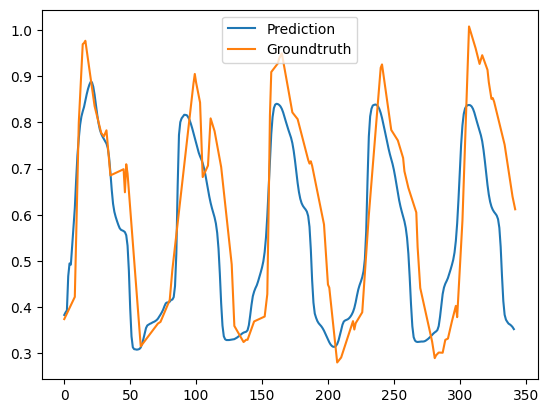

In [ ]:
# Plot groundtruth and prediction for a random pixel
# The fit is not as good as on the training Fontainebleau data.
random_pixel = (rd.randint(0,predictions.shape[1]-1), rd.randint(0,predictions.shape[1]-1))
band = 6
print(f"Band {band}")

plt.plot(predictions[:,random_pixel[0],random_pixel[1],band], label='Prediction')
plt.plot(np.where(mask_test==1)[0], data_test_small[:,random_pixel[0],random_pixel[1],band][mask_test==1], label='Groundtruth')
plt.legend()

In [ ]:
nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed {seed}")
  LSTM.load_state_dict(torch.load(trained_models_path+f'best_LSTM_{seed}.pt'))
  time_span = 342 - initial_time
  predictions = torch.zeros(time_span,data_test_small.shape[1],data_test_small.shape[2],20, device='cpu')

  #input = torch.zeros(2048,20).to(device)
  for batch in range(data_test_small.shape[1]) :
    LSTM.eval()
    input = initial_state_total[batch]
    prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
    #print(prediction.shape)
    predictions[:,batch,:,:] = prediction.permute((1,0,2))
  MSE = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[mask_test[initial_time+1:]==1] **2)
  MSE_intra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100][mask_test[initial_time+1:-100]==1] **2)
  MSE_extra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:][mask_test[-100:]==1] **2)
  print(f"Global MSE : {MSE}")
  print(f"MSE on training period : {MSE_intra}")
  print(f"MSE on validation period : {MSE_extra}")
  MSE_list[seed] = MSE_extra
print(f"Mean and standard deviation of the extrapolation error over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed 0
Global MSE : 0.010369187220931053
MSE on training period : 0.010119155049324036
MSE on validation period : 0.010869251564145088
Seed 1
Global MSE : 0.01145399734377861
MSE on training period : 0.010626759380102158
MSE on validation period : 0.013108471408486366
Seed 2
Global MSE : 0.010510685853660107
MSE on training period : 0.010291201062500477
MSE on validation period : 0.010949653573334217
Seed 3
Global MSE : 0.011885003186762333
MSE on training period : 0.010470381006598473
MSE on validation period : 0.01471424475312233
Seed 4
Global MSE : 0.011413970962166786
MSE on training period : 0.009973946027457714
MSE on validation period : 0.014294024556875229
Mean and standard deviation of the extrapolation error over 5 seeds: 0.012787129171192646 +- 0.0016212550750154175


Here, the result should be 0.0128 +- 0.0016.

## Assimilation-forecasting on Fontainebleau

In [ ]:
# Perform the assimilation for one of the models
# This requires a few minutes, even with a GPU.

path = trained_models_path + 'best_LSTM_0.pt'
LSTM.load_state_dict(torch.load(path))
initial_time = 1
time_span = 242 - initial_time
print(data_small.shape)
# size = 50 # Lower memory GPU
size = 100 # Requires high memory GPU. Set it to a lower size if you have a GPU memory error.
nb_rows = 25
predictions = torch.zeros((time_span,size,size,20), device='cpu')
inputs = torch.zeros((size, size, 20), device='cpu')
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
print(predictions.shape)
criterion = nn.MSELoss()
loss_every = 10

for batch in range(size//nb_rows) :
  print(f'Rows {batch*nb_rows} to {(batch+1)*nb_rows} of {size}')
  LSTM.train()
  input = torch.zeros(nb_rows,size,20).to(device)
  input[:,:,:10] = torch.clone(reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time]).to(device).permute((1,2,0))
  input[:,:,10:] = torch.clone(reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time]
                              - reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time-1]).to(device).permute((1,2,0))
  input = input
  input = torch.clone(input).detach().requires_grad_()
  epochs = 200
  opt = torch.optim.Adam([input], lr=1e-4)
  for epoch in range(epochs):
    opt.zero_grad()
    prediction = LSTM(input.flatten(0,1).unsqueeze(1), time_span, 1).reshape((nb_rows,size,time_span,20))
    loss = mse_loss(prediction.permute((3,0,1,2))[:10], reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:,initial_time+1:time_span+initial_time+1])
    loss.backward()
    opt.step()
    if epoch % loss_every == 0:
      print(f"Epoch {epoch}: loss = {loss.item()}")
  inputs[batch*nb_rows:(batch+1)*nb_rows] = input.cpu().detach()

(343, 100, 100, 10)
torch.Size([241, 100, 100, 20])
Rows 0 to 25 of 100
Epoch 0: loss = 413.1122131347656
Epoch 10: loss = 199.5635528564453
Epoch 20: loss = 169.055419921875
Epoch 30: loss = 151.9141845703125
Epoch 40: loss = 142.09024047851562
Epoch 50: loss = 135.3422088623047
Epoch 60: loss = 130.32814025878906
Epoch 70: loss = 126.51415252685547
Epoch 80: loss = 122.837158203125
Epoch 90: loss = 120.19526672363281
Epoch 100: loss = 117.7883529663086
Epoch 110: loss = 115.76142883300781
Epoch 120: loss = 114.1683578491211
Epoch 130: loss = 112.82380676269531
Epoch 140: loss = 111.5959701538086
Epoch 150: loss = 110.55482482910156
Epoch 160: loss = 109.40914154052734
Epoch 170: loss = 108.6130142211914
Epoch 180: loss = 107.80010986328125
Epoch 190: loss = 107.4560546875
Rows 25 to 50 of 100
Epoch 0: loss = 432.3214416503906
Epoch 10: loss = 184.43081665039062
Epoch 20: loss = 153.6609649658203
Epoch 30: loss = 138.2176055908203
Epoch 40: loss = 129.95506286621094
Epoch 50: loss = 1

In [ ]:
# Assimilation errors. The assimilated data are very well fit,
# and the error on test data is relatively moderately improved compared to predicting from time 0.
time_span = 342 - initial_time
predictions = torch.zeros(time_span,size,size,20, device='cpu')
for batch in range(size) :
  LSTM.eval()
  input = inputs[batch].to(device)
  prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
  predictions[:,batch,:,:] = prediction.permute((1,0,2))
MSE = torch.mean((torch.Tensor(data_small[initial_time+1:,:size,:size]) - predictions[:,:,:,:10]) **2)
MSE_intra = torch.mean((torch.Tensor(data_small[initial_time+1:,:size,:size]) - predictions[:,:,:,:10])[:-100] **2)
MSE_extra = torch.mean((torch.Tensor(data_small[initial_time+1:,:size,:size]) - predictions[:,:,:,:10])[-100:] **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on test period : {MSE_extra}")

Global MSE : 0.0005897906376048923
MSE on training period : 0.00017315497098024935
MSE on test period : 0.0015938825672492385


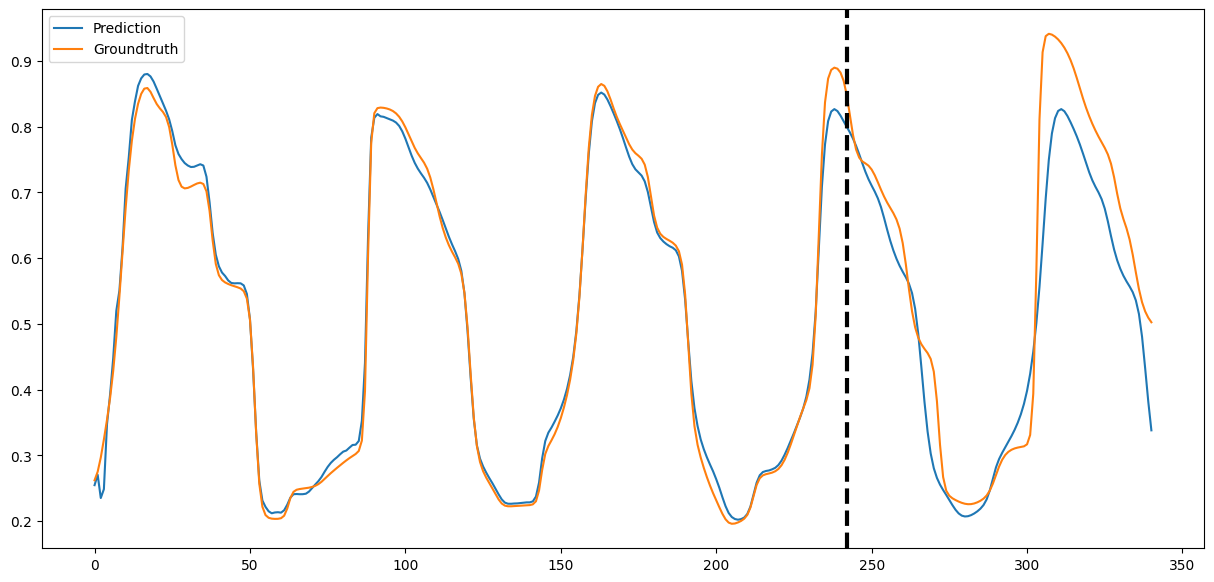

In [ ]:
# Results for one random pixel. The vertical line marks the limit between the training (assimilated) and test data.
# Generally speaking, the assimilated data are very well fit but the extrapolation is imperfect.

pix = rd.randint(0,size-1), rd.randint(0,size-1)
band = 6

plt.figure(figsize=(15,7))
plt.plot(predictions[:,pix[0],pix[1],band], label='Prediction')
plt.plot(data_small[initial_time+1:,pix[0],pix[1],band], label='Groundtruth')
plt.axvline([242], 0, 1, c='black', linestyle='dashed', linewidth=3)
plt.legend()

In [ ]:
# Perform data assimilation for the 5 LSTM models.
# This takes a lot of time.

nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed {seed}")
  LSTM.load_state_dict(torch.load(trained_models_path+f'best_LSTM_{seed}.pt'))
  time_span = 241
  # size = 50 # Lower memory GPU
  size = 100 # Requires high memory GPU. Set it to a lower size if you have a GPU memory error.
  nb_rows = 25
  predictions = torch.zeros((time_span,size,size,20), device='cpu')
  inputs = torch.zeros((size, size, 20), device='cpu')
  reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)
  criterion = nn.MSELoss()
  loss_every = 10

  for batch in range(size//nb_rows) :
    print(f'Rows {batch*nb_rows} to {(batch+1)*nb_rows} of {size}')
    LSTM.train()
    input = torch.zeros(nb_rows,size,20).to(device)
    input[:,:,:10] = torch.clone(reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time]).to(device).permute((1,2,0))
    input[:,:,10:] = torch.clone(reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time]
                                - reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:size,initial_time-1]).to(device).permute((1,2,0))
    input = input
    input = torch.clone(input).detach().requires_grad_()
    epochs = 301
    opt = torch.optim.Adam([input], lr=1e-4)
    for epoch in range(epochs):
      opt.zero_grad()
      prediction = LSTM(input.flatten(0,1).unsqueeze(1), time_span, 1).reshape((nb_rows,size,time_span,20))
      loss = mse_loss(prediction.permute((3,0,1,2))[:10], reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:,initial_time+1:time_span+initial_time+1])
      loss.backward()
      opt.step()
      if epoch % loss_every == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")
    inputs[batch*nb_rows:(batch+1)*nb_rows] = input.cpu().detach()
  time_span = 342 - initial_time
  predictions = torch.zeros(time_span,size,size,20, device='cpu')
  for batch in range(size) :
    LSTM.eval()
    input = inputs[batch].to(device)
    prediction = LSTM(input.unsqueeze(1), time_span, 1).cpu().detach()
    predictions[:,batch,:,:] = prediction.permute((1,0,2))
  MSE = torch.mean((torch.Tensor(data_small[initial_time+1:,:size,:size]) - predictions[:,:,:,:10])[-100:] **2)
  MSE_list[seed] = MSE
  print(f"Seed {seed}: MSE = {MSE}")
print(f"Average MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed 0
Rows 0 to 25 of 100
Epoch 0: loss = 413.1122131347656
Epoch 10: loss = 199.5635528564453
Epoch 20: loss = 169.055419921875
Epoch 30: loss = 151.9141845703125
Epoch 40: loss = 142.09024047851562
Epoch 50: loss = 135.3422088623047
Epoch 60: loss = 130.32814025878906
Epoch 70: loss = 126.51415252685547
Epoch 80: loss = 122.837158203125
Epoch 90: loss = 120.19526672363281
Epoch 100: loss = 117.7883529663086
Epoch 110: loss = 115.76142883300781
Epoch 120: loss = 114.1683578491211
Epoch 130: loss = 112.82380676269531
Epoch 140: loss = 111.5959701538086
Epoch 150: loss = 110.55482482910156
Epoch 160: loss = 109.40914154052734
Epoch 170: loss = 108.6130142211914
Epoch 180: loss = 107.80010986328125
Epoch 190: loss = 107.4560546875
Epoch 200: loss = 106.8880386352539
Epoch 210: loss = 106.18878173828125
Epoch 220: loss = 105.77315521240234
Epoch 230: loss = 105.38408660888672
Epoch 240: loss = 104.8666000366211
Epoch 250: loss = 104.34126281738281
Epoch 260: loss = 103.9035415649414
Epoc

Final result : 0.00150 +- 0.00008

## Assimilation-forecasting on Orléans

In [ ]:
# One model

# size = 50 # Lower memory GPU
size = 100 # Requires high memory GPU. Set it to a lower size if you have a GPU memory error.
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:size,:size,0] * (second_date - 1) + reflectances_test[:,:size,:size,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:size,:size,second_date] - reflectances_test[:,:size,:size,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device)))

nb_seeds = 5
path = trained_models_path + 'best_LSTM_0.pt'
LSTM.load_state_dict(torch.load(path))
time_span = 241
size = 100
nb_rows = 25
predictions = torch.zeros((time_span,size,size,20), device='cpu')
inputs = torch.zeros((size, size, 20), device='cpu')
reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)
criterion = nn.MSELoss()
loss_every = 10

for batch in range(size//nb_rows) :
  print(f'Rows {batch*nb_rows} to {(batch+1)*nb_rows} of {size}')
  LSTM.train()
  input = torch.zeros(nb_rows,size,20).to(device)
  input = initial_state_total[:,batch*nb_rows:(batch+1)*nb_rows].permute((1,2,0))
  input = torch.clone(input).detach().requires_grad_()
  epochs = 301
  opt = torch.optim.Adam([input], lr=1e-4)
  for epoch in range(epochs):
    opt.zero_grad()
    prediction = LSTM(input.flatten(0,1).unsqueeze(1), time_span, 1).reshape((nb_rows,size,time_span,20))
    loss = mse_loss(prediction.permute((3,0,1,2))[:10][:,:,:,mask_test[1:time_span+1]==1],
                    reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:,1:time_span+1][:,:,:,mask_test[1:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % loss_every == 0:
      print(f"Epoch {epoch}: loss = {loss.item()}")
  inputs[batch*nb_rows:(batch+1)*nb_rows] = input.cpu().detach()
time_span_complete = 342
time_span_train = 242
predictions = torch.zeros(time_span_complete,size,size,20, device='cpu')
for batch in range(size) :
  LSTM.eval()
  input = inputs[batch].to(device)
  prediction = LSTM(input.unsqueeze(1), time_span_complete, 1).cpu().detach()
  predictions[:,batch,:,:] = prediction.permute((1,0,2))
MSE = torch.mean((torch.Tensor(data_test_small[1:,:size,:size]) - predictions[:,:,:,:10])[time_span_train:][mask_test[1+time_span_train:]==1] **2)
print(f"MSE = {MSE}")

Rows 0 to 25 of 100
Epoch 0: loss = 1661.3265380859375
Epoch 10: loss = 1157.8935546875
Epoch 20: loss = 1003.7269897460938
Epoch 30: loss = 920.3632202148438
Epoch 40: loss = 864.7804565429688
Epoch 50: loss = 825.5466918945312
Epoch 60: loss = 794.129150390625
Epoch 70: loss = 771.1100463867188
Epoch 80: loss = 751.5400390625
Epoch 90: loss = 735.0523681640625
Epoch 100: loss = 719.7904663085938
Epoch 110: loss = 705.4432983398438
Epoch 120: loss = 693.6395263671875
Epoch 130: loss = 683.6912231445312
Epoch 140: loss = 671.1267700195312
Epoch 150: loss = 660.0890502929688
Epoch 160: loss = 652.812255859375
Epoch 170: loss = 644.0344848632812
Epoch 180: loss = 634.4360961914062
Epoch 190: loss = 627.7546997070312
Epoch 200: loss = 620.1091918945312
Epoch 210: loss = 613.9252319335938
Epoch 220: loss = 608.15576171875
Epoch 230: loss = 601.8309936523438
Epoch 240: loss = 597.140625
Epoch 250: loss = 593.3377685546875
Epoch 260: loss = 589.4103393554688
Epoch 270: loss = 585.57293701171

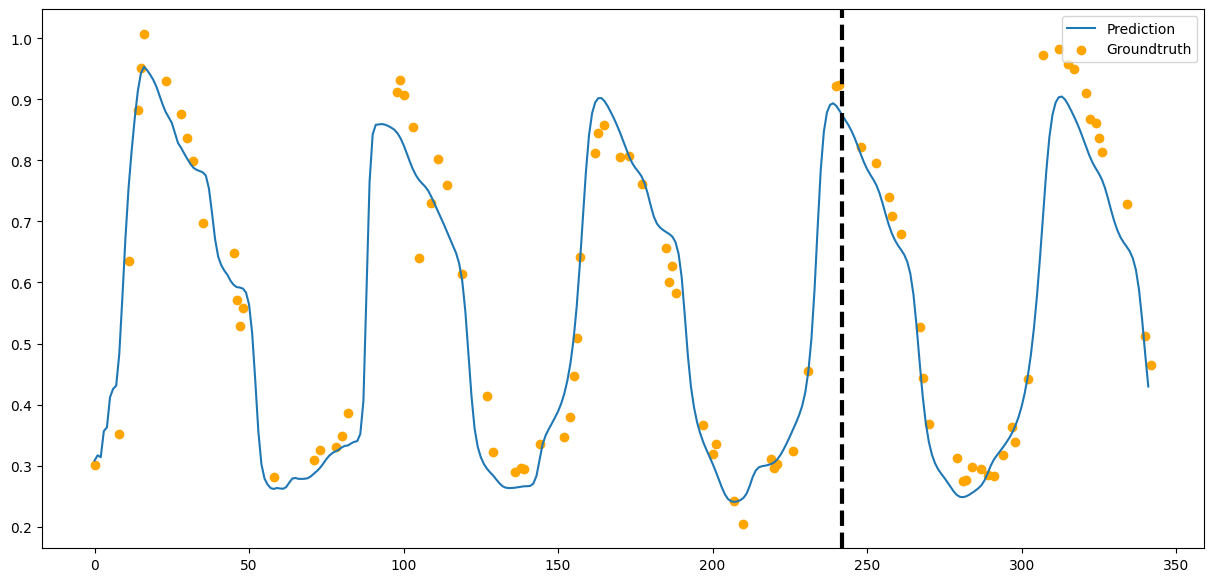

In [ ]:
# See results for a random pixel

pix = rd.randint(0,size-1), rd.randint(0,size-1)
band = 6

plt.figure(figsize=(15,7))
plt.plot(predictions[:,pix[0],pix[1],band], label='Prediction')
plt.scatter(np.where(mask_test==1)[0], data_test_small[:,pix[0],pix[1],band][mask_test==1], c='orange', label='Groundtruth')
plt.axvline([242], 0, 1, c='black', linestyle='dashed', linewidth=3)
plt.legend()

In [ ]:
# Test several models
size = 100
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:size,:size,0] * (second_date - 1) + reflectances_test[:,:size,:size,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:size,:size,second_date] - reflectances_test[:,:size,:size,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device)))
print(initial_state_total.shape)

nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed {seed}")
  LSTM.load_state_dict(torch.load(trained_models_path+f'best_LSTM_{seed}.pt'))
  time_span = 241
  size = 100
  nb_rows = 25
  predictions = torch.zeros((time_span,size,size,20), device='cpu')
  inputs = torch.zeros((size, size, 20), device='cpu')
  reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)
  criterion = nn.MSELoss()
  loss_every = 10

  for batch in range(size//nb_rows) :
    print(f'Rows {batch*nb_rows} to {(batch+1)*nb_rows} of {size}')
    LSTM.train()
    input = torch.zeros(nb_rows,size,20).to(device)
    input = initial_state_total[:,batch*nb_rows:(batch+1)*nb_rows].permute((1,2,0))
    input = torch.clone(input).detach().requires_grad_()
    epochs = 301
    opt = torch.optim.Adam([input], lr=1e-4)
    for epoch in range(epochs):
      opt.zero_grad()
      prediction = LSTM(input.flatten(0,1).unsqueeze(1), time_span, 1).reshape((nb_rows,size,time_span,20))
      loss = mse_loss(prediction.permute((3,0,1,2))[:10][:,:,:,mask_test[1:time_span+1]==1],
                      reflectances_cuda[:,batch*nb_rows:(batch+1)*nb_rows,:,1:time_span+1][:,:,:,mask_test[1:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % loss_every == 0:
        print(f"Epoch {epoch}: loss = {loss.item()}")
    inputs[batch*nb_rows:(batch+1)*nb_rows] = input.cpu().detach()
  time_span_complete = 342
  time_span_train = 242
  predictions = torch.zeros(time_span_complete,size,size,20, device='cpu')
  for batch in range(size) :
    LSTM.eval()
    input = inputs[batch].to(device)
    prediction = LSTM(input.unsqueeze(1), time_span_complete, 1).cpu().detach()
    predictions[:,batch,:,:] = prediction.permute((1,0,2))
  MSE = torch.mean((torch.Tensor(data_test_small[1:,:size,:size]) - predictions[:,:,:,:10])[time_span_train:][mask_test[1+time_span_train:]==1] **2)
  MSE_list[seed] = MSE
  print(f"Seed {seed}: MSE = {MSE}")
print(f"Average MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

torch.Size([20, 100, 100])
Seed 0
Rows 0 to 25 of 100
Epoch 0: loss = 1661.3265380859375
Epoch 10: loss = 1157.8935546875
Epoch 20: loss = 1003.7269897460938
Epoch 30: loss = 920.3632202148438
Epoch 40: loss = 864.7804565429688
Epoch 50: loss = 825.5466918945312
Epoch 60: loss = 794.129150390625
Epoch 70: loss = 771.1100463867188
Epoch 80: loss = 751.5400390625
Epoch 90: loss = 735.0523681640625
Epoch 100: loss = 719.7904663085938
Epoch 110: loss = 705.4432983398438
Epoch 120: loss = 693.6395263671875
Epoch 130: loss = 683.6912231445312
Epoch 140: loss = 671.1267700195312
Epoch 150: loss = 660.0890502929688
Epoch 160: loss = 652.812255859375
Epoch 170: loss = 644.0344848632812
Epoch 180: loss = 634.4360961914062
Epoch 190: loss = 627.7546997070312
Epoch 200: loss = 620.1091918945312
Epoch 210: loss = 613.9252319335938
Epoch 220: loss = 608.15576171875
Epoch 230: loss = 601.8309936523438
Epoch 240: loss = 597.140625
Epoch 250: loss = 593.3377685546875
Epoch 260: loss = 589.4103393554688

Final result should be 0.00542 +- 0.00083

# Linear model

This simple model is much faster to train, so feel free to perform the training by yourself. You can also directly download the trained matrix using the cell below.

In [22]:
K = torch.load('Sentinel2TS/Benchmark/Linear/best_K.pt')

## Training

In [ ]:
K = torch.eye(state_batches.shape[-1], requires_grad=True, device=device)
# You can try initialising the model differently, but the initialisation from I performed best in our tests
K = torch.clone(K).detach()
K.requires_grad_()
epochs = 500
opt = torch.optim.Adam([K], lr=1e-3)
max_patience = 50
patience = 0
time_span = 100
alpha = 0
lamda = 100.
lamda = 10.
lamda = 0.
best_epoch, best_val = 0, 1e15
last_train_index = 53
train_losses = []
val_losses = []
val_losses2 = []
val_losses3 = []
starting_point = 0
loss_every = 1

for epoch in range(epochs+1) :
  if patience >= max_patience:
    print(f'Early stopping due to no more improvement. Best validation MSE: {best_val}')
    break
  epoch_loss = 0
  epoch_val_loss = 0
  for batch in range(nb_batches) :
    opt.zero_grad()
    x0 = state_batches[0,batch].T.to(device)
    gt = state_batches[:,batch].to(device)
    xt = [x0]
    for t in range(time_span):
      xt.append(torch.matmul(K, xt[-1]))
    xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
    loss = 0
    # Prediction loss
    loss += mse_loss(xt, gt)
    # Orthogonality loss
    loss += lamda * mse_loss(torch.matmul(K, K.T), torch.eye(state_batches.shape[-1]).to(device))
    loss.backward()
    opt.step()
    epoch_loss += loss.detach().item()
  epoch_loss /= nb_batches
  train_losses.append(epoch_loss)
  val_loss = 0
  x0 = states_val[0].T.to(device)
  gt = states_val.to(device)
  xt = [x0]
  for t in range(time_span):
    xt.append(torch.matmul(K, xt[-1]))
  xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
  loss = 0
  # Prediction loss
  val_loss += mse_loss(xt, gt)
  # Orthogonality loss
  orth_loss = lamda * mse_loss(torch.matmul(K, K.T), torch.eye(state_batches.shape[-1]).to(device))
  val_loss += orth_loss
  val_losses2.append(val_loss.item())
  #epoch_val_loss = val_loss.item()

  whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
  for column in range(data_small.shape[1] // 10) :
    states = torch.Tensor(data_small[1:,10*column]).to(device)
    states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
    x0 = states[0].T
    xt = [x0]
    for t in range(whole_predictions.shape[0]-1):
      xt.append(torch.matmul(K, xt[-1]))
    xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
    whole_predictions[starting_point:, column] = xt[:,:,:10].cpu().detach()

  val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
  val_losses3.append(val_loss3.item())
  epoch_val_loss = val_loss3.item()
  if epoch % loss_every == 0 :
    print(f"Epoch {epoch+1} : Train loss {train_losses[-1]}, validation loss {val_losses2[-1]}, orthogonality loss {orth_loss}")
    print(f"Complete prediction MSE : {val_losses3[-1]}")
  if epoch_val_loss < best_val : # Save the model parameters
    best_val = epoch_val_loss
    best_epoch = epoch
    torch.save(K, 'best_K.pt')
    patience = 0
    print('Saving model')
  else:
    patience += 1

## Evaluation

In [63]:
# Fontainebleau

size = 100
time_span = 241
reflectances = torch.Tensor(data_small.transpose(3,1,2,0))
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).flatten(1,2)
xt = [initial_state_total]
for k in range(reflectances.shape[-1]-2) :
  xt.append(torch.matmul(K, xt[-1]))
xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
predictions = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
print(predictions.shape, reflectances.shape)
MSE = torch.mean((predictions[:10].cpu().detach() - reflectances[:,:size,:size,1:])[:,:,:,time_span+1:] **2)
print(f"Final test MSE : {MSE}")

torch.Size([20, 100, 100, 342]) torch.Size([10, 150, 150, 343])
Final test MSE : 0.004324362613260746


In [64]:
# Orléans

reflectances_test = data_test_small.transpose(3,1,2,0)
size = 100
time_span = 241
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:size,:size,0] * (second_date - 1) + reflectances_test[:,:size,:size,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:size,:size,second_date] - reflectances_test[:,:size,:size,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).flatten(1,2)
xt = [initial_state_total]
for k in range(reflectances.shape[-1]-2) :
  xt.append(torch.matmul(K, xt[-1]))
xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
predictions = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
print(predictions.shape, reflectances.shape)
MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_test[:,:size,:size,1:])[:,:,:,time_span+1:][:,:,:,mask_test[time_span+2:]==1] **2)
print(f"Final test MSE : {MSE}")

torch.Size([20, 100, 100, 342]) torch.Size([10, 150, 150, 343])
Final test MSE : 0.009794570505619049


Band 6


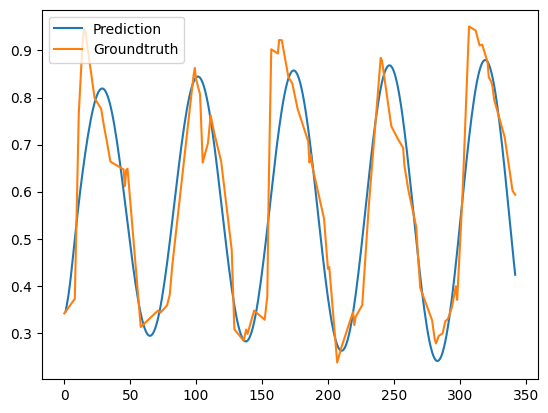

In [68]:
# Visualise prediction for a random pixel

random_pixel = (rd.randint(0,predictions.shape[1]-1), rd.randint(0,predictions.shape[1]-1))
band = 6
print(f'Band {band}')

plt.plot([k+1 for k in range(predictions.shape[3])], predictions[band,random_pixel[0],random_pixel[1]].cpu().detach(), label='Prediction')
plt.plot(np.where(mask_test==1)[0], data_test_small[:,random_pixel[0],random_pixel[1],band][mask_test==1], label='Groundtruth')
plt.legend()

## Assimilation-forecasting on Fontainebleau

In [ ]:
size = 100 # Since there is no decoding to perform, running everything in parallel should not be problematic.
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).flatten(1,2)
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

initial_state_total = torch.clone(initial_state_total).detach()
initial_state_total = initial_state_total.requires_grad_()
predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)
epochs = 201
opt = torch.optim.Adam([initial_state_total], lr=2e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  xt = [initial_state_total]
  for k in range(time_span) :
    xt.append(torch.matmul(K, xt[-1]))
  xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
  xt = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
  #print(xt.shape, reflectances.shape)
  loss = mse_loss(xt[:10], reflectances_cuda[:,:,:,1:time_span+2])
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

xt = [initial_state_total]
for k in range(predictions.shape[-1]-1) :
  xt.append(torch.matmul(K, xt[-1]))
xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
predictions = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
print(f"Final test MSE : {MSE}")

Epoch 0 : loss 9952.7890625
Epoch 10 : loss 5859.72119140625
Epoch 20 : loss 5401.43115234375
Epoch 30 : loss 5156.203125
Epoch 40 : loss 5025.57421875
Epoch 50 : loss 4955.81787109375
Epoch 60 : loss 4914.8525390625
Epoch 70 : loss 4888.9873046875
Epoch 80 : loss 4870.81005859375
Epoch 90 : loss 4856.90185546875
Epoch 100 : loss 4845.5
Epoch 110 : loss 4835.7216796875
Epoch 120 : loss 4827.10009765625
Epoch 130 : loss 4819.3671875
Epoch 140 : loss 4812.35498046875
Epoch 150 : loss 4805.95068359375
Epoch 160 : loss 4800.06982421875
Epoch 170 : loss 4794.64990234375
Epoch 180 : loss 4789.6396484375
Epoch 190 : loss 4784.9970703125
Epoch 200 : loss 4780.68701171875
Final test MSE : 0.0021317140199244022


Model initiated from identity: final MSE 0.0021317140199244022

torch.Size([20, 100, 100, 342])


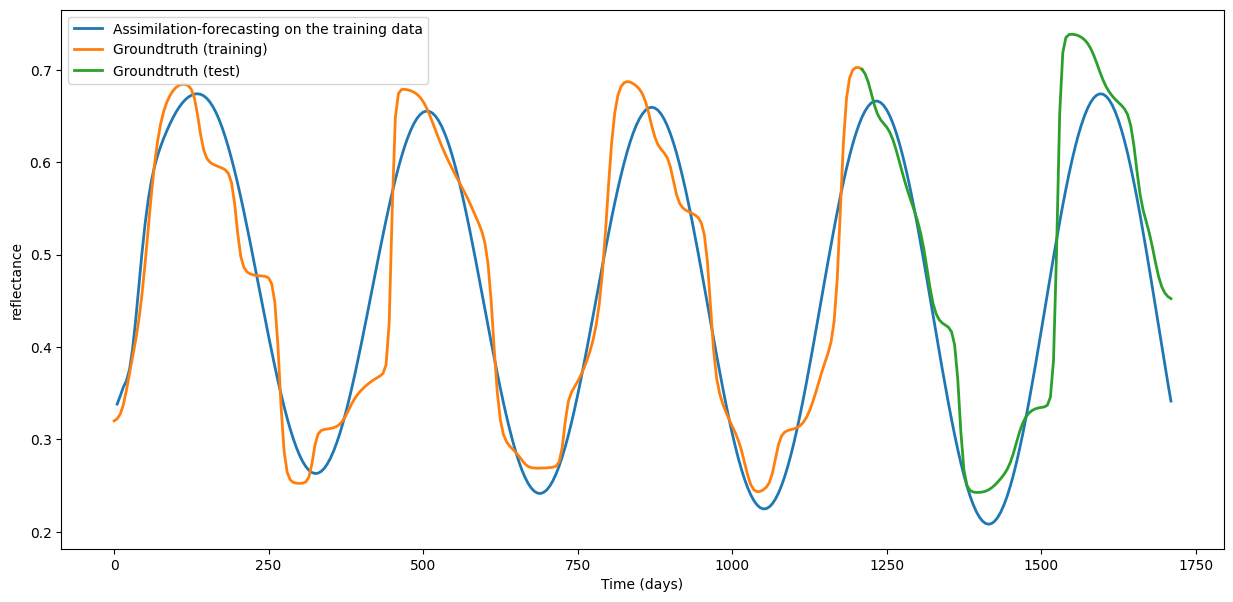

In [ ]:
# Visualise predictions on one pixel
pix = (rd.randint(0,99), rd.randint(0,99))
band = 6
print(predictions.shape)
X = [5*k for k in range(reflectances_cuda.shape[3])]
plt.figure(figsize=(15,7))
plt.ylabel('reflectance')
plt.xlabel('Time (days)')
plt.plot(X[1:], predictions[band,pix[0],pix[1]].cpu().detach(), linewidth=2, label='Assimilation-forecasting on the training data')
plt.plot(X[:time_span+2], reflectances_cuda[band,pix[0],pix[1],:time_span+2].cpu().detach(), linewidth=2, label='Groundtruth (training)')
plt.plot(X[time_span+1:], reflectances_cuda[band,pix[0],pix[1],time_span+1:].cpu().detach(), linewidth=2, label='Groundtruth (test)')
plt.legend()

## Assimilation-forecasting on Orléans

In [ ]:
reflectances_test = data_test_small.transpose(3,1,2,0)
size = 100
time_span = 241
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:size,:size,0] * (second_date - 1) + reflectances_test[:,:size,:size,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:size,:size,second_date] - reflectances_test[:,:size,:size,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).flatten(1,2)
reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

initial_state_total = torch.clone(initial_state_total).detach()
initial_state_total = initial_state_total.requires_grad_()
predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                            reflectances_cuda.shape[1],
                            reflectances_cuda.shape[2],
                            reflectances_cuda.shape[3]-1))#.to(device)
epochs = 201
opt = torch.optim.Adam([initial_state_total], lr=2e-3)
losses = []
for epoch in range(epochs) :
  opt.zero_grad()
  xt = [initial_state_total]
  for k in range(time_span) :
    xt.append(torch.matmul(K, xt[-1]))
  xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
  xt = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
  loss = mse_loss(xt[:10][:,:,:,mask_test[:time_span+1]==1], reflectances_cuda[:,:,:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
  loss.backward()
  opt.step()
  if epoch % 10 == 0 :
    print(f"Epoch {epoch} : loss {loss.item()}")

xt = [initial_state_total]
for k in range(reflectances_cuda.shape[3]-1) :
  xt.append(torch.matmul(K, xt[-1]))
xt = torch.cat(tuple(x.unsqueeze(0) for x in xt), dim=0).permute((0,2,1))
predictions = xt.reshape((xt.shape[0], size, size, xt.shape[2])).permute((3,1,2,0))
MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2)
print(f"Final test MSE : {MSE}")

Epoch 0 : loss 8017.66162109375
Epoch 10 : loss 4993.3515625
Epoch 20 : loss 4189.29541015625
Epoch 30 : loss 3876.88916015625
Epoch 40 : loss 3712.662109375
Epoch 50 : loss 3608.398193359375
Epoch 60 : loss 3537.561767578125
Epoch 70 : loss 3488.534912109375
Epoch 80 : loss 3453.362548828125
Epoch 90 : loss 3426.99072265625
Epoch 100 : loss 3406.35791015625
Epoch 110 : loss 3389.591552734375
Epoch 120 : loss 3375.51806640625
Epoch 130 : loss 3363.392333984375
Epoch 140 : loss 3352.73046875
Epoch 150 : loss 3343.21533203125
Epoch 160 : loss 3334.627685546875
Epoch 170 : loss 3326.814453125
Epoch 180 : loss 3319.661865234375
Epoch 190 : loss 3313.08251953125
Epoch 200 : loss 3307.00830078125
Final test MSE : 0.004328520502895117


Model initiated from identity: final MSE 0.004328520502895117

torch.Size([20, 100, 100, 343])


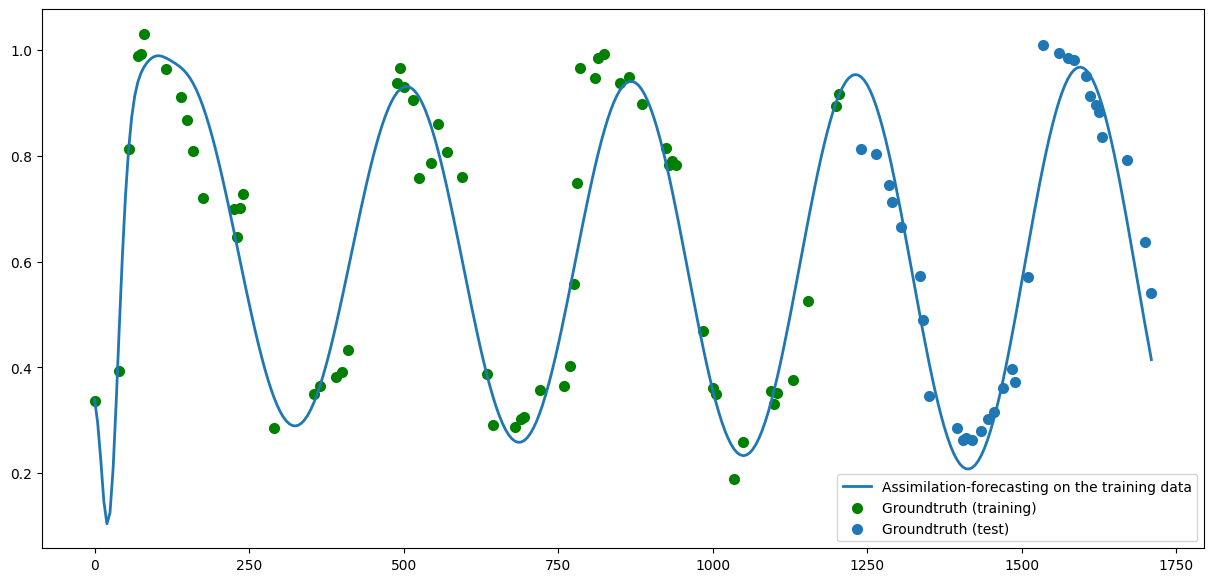

In [ ]:
pix = (rd.randint(0,99), rd.randint(0,99))
band = 6
print(predictions.shape)
X = np.array([5*k for k in range(reflectances_cuda.shape[3])])
plt.figure(figsize=(15,7))
plt.plot(X, predictions[band,pix[0],pix[1]].cpu().detach(), linewidth=2, label='Assimilation-forecasting on the training data')
plt.scatter(X[:time_span+2][mask_test[:time_span+2]==1], reflectances_cuda[band,pix[0],pix[1],:time_span+2][mask_test[:time_span+2]==1].cpu().detach(),
            c='green', linewidth=2, label='Groundtruth (training)')
plt.scatter(X[time_span+1:][mask_test[time_span+1:]==1], reflectances_cuda[band,pix[0],pix[1],time_span+1:][mask_test[time_span+1:]==1].cpu().detach(),
            linewidth=2, label='Groundtruth (test)')
plt.legend()

Although the long-term behaviour of the model is quite sound, it still has a very strange behaviour in the beginning of the prediction (which is not penalized by the assimilation cost function since there is no available groundtruth for these time indexes)

# Ours

## Model

In [12]:
from Sentinel2TS import KoopmanAE

model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

## Training (with orthogonality loss)

In [ ]:
torch.manual_seed(0)
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 300596
KoopmanAE(
  (encoder): ModuleList(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  opt = model.configure_optimizers(lr=1e-3)
  max_patience = 50
  patience = 0
  time_span = 100
  alpha = 0
  lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt)
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, latent_states.shape, gt.shape)
      loss += model.mse_loss(model.decode(phis), gt)
      # Reconstruction loss
      loss += model.mse_loss(model.decode(latent_states), gt)
      # Linearity loss
      loss += model.mse_loss(phis, latent_states)
      # Orthogonality loss
      loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device))
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    loss = 0
    # Prediction loss
    val_loss += model.mse_loss(model.decode(phis), gt)
    # Reconstruction loss
    val_loss += model.mse_loss(model.decode(latent_states), gt)
    # Linearity loss
    val_loss += model.mse_loss(phis, latent_states)
    # Orthogonality loss
    val_loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device))
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()

    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis)
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'/best_model_{seed}.pt')
      torch.save(model.K, models_path+f'/best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1

## Training (without orthogonality loss)

In [ ]:
torch.manual_seed(0)
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 300596
KoopmanAE(
  (encoder): ModuleList(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  #opt = model.configure_optimizers(lr=5e-4)
  opt = model.configure_optimizers(lr=1e-3)
  #opt = model.configure_optimizers(lr=2e-3)
  #scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.999)
  max_patience = 50
  patience = 0
  #scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 1e-3, 8e-3, 10)
  time_span = 100
  alpha = 0
  lamda = 0
  #lamda = 10.
  #lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt)
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, model.decode(phis).shape, gt.shape)
      loss += model.mse_loss(model.decode(phis), gt)
      # Reconstruction loss
      loss += model.mse_loss(model.decode(latent_states), gt)
      # Linearity loss
      loss += model.mse_loss(phis, latent_states)
      # Orthogonality loss
      loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device))
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    loss = 0
    # Prediction loss
    val_loss += model.mse_loss(model.decode(phis), gt)
    # Reconstruction loss
    val_loss += model.mse_loss(model.decode(latent_states), gt)
    # Linearity loss
    val_loss += model.mse_loss(phis, latent_states)
    # Orthogonality loss
    val_loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device))
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()

    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis)
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'/best_model_{seed}.pt')
      torch.save(model.K, models_path+f'/best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1


## Evaluation on Fontainebleau

In [49]:
trained_models_path = 'Sentinel2TS/Benchmark/WithOrth/' # Models trained with orthogonality loss
#trained_models_path = 'Sentinel2TS/Benchmark/WithoutOrth/' # Models trained without orthogonality loss

model.load_state_dict(torch.load(trained_models_path + 'best_model_0.pt')) # Load one model from either category
model.K = torch.load(trained_models_path + 'best_K_0.pt')

In [ ]:
data_small = data[:,:,250:400,250:400].transpose(0,2,3,1) #150x150
data_small = data_small[:,:100,:100] # use the 100x100 square to match the spatial assimilation data
print(data_small.shape)

(343, 100, 100, 10)


In [ ]:
# Prediction for one model
initial_time = 1
time_span = 342 - initial_time
predictions = torch.zeros(time_span,data_small.shape[1],data_small.shape[2],20, device='cpu')

for batch in range(data_small.shape[1]) :
  model.eval()
  input = torch.zeros(data_small.shape[2],20).to(device)
  input[:, :10] = torch.tensor(data_small[initial_time,batch,:,:], device=device)
  input[:, 10:] = torch.tensor(data_small[initial_time,batch,:,:]
                              -data_small[initial_time-1,batch,:,:], device=device)

  xt, phis = model.forward_n_remember(input, time_span)
  prediction = model.decode(phis)[1:].cpu().detach()
  predictions[:,batch,:,:] = prediction

In [ ]:
# Error for one model
print(data_small.shape, predictions.shape)
MSE = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10]) **2)
MSE_intra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100] **2)
MSE_extra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:] **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on validation period : {MSE_extra}")

(343, 100, 100, 10) torch.Size([341, 100, 100, 20])
Global MSE : 0.0014152625808492303
MSE on training period : 0.0010940170614048839
MSE on validation period : 0.002189463470131159


Band 5


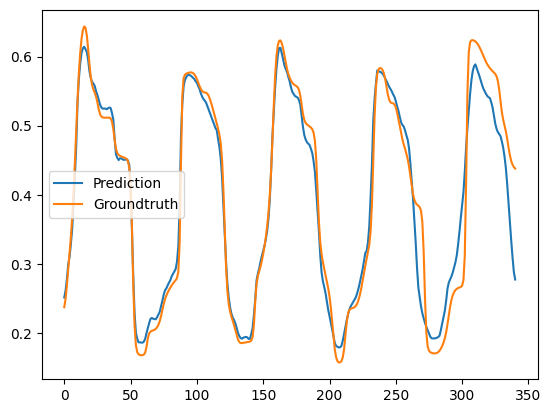

In [ ]:
# Visualise predictions for random pixels

random_pixel = (rd.randint(0,predictions.shape[1]-1), rd.randint(0,predictions.shape[1]-1))
band = 6
band = rd.randint(0,9)
print(f'Band {band}')

plt.plot(predictions[:,random_pixel[0],random_pixel[1],band], label='Prediction')
plt.plot(data_small[initial_time+1:,random_pixel[0],random_pixel[1],band], label='Groundtruth')
plt.legend()

In [ ]:
# Select one of the paths to get the corresponding results
#trained_models_path = 'Sentinel2TS/Benchmark/WithOrth/' # Models trained with orthogonality loss
trained_models_path = 'Sentinel2TS/Benchmark/WithoutOrth/' # Models trained without orthogonality loss

nb_seeds = 5
initial_time = 1
time_span = 342 - initial_time
MSE_extra_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed number {seed}")
  predictions = torch.zeros(time_span,data_small.shape[1],data_small.shape[2],20, device='cpu')
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  for batch in range(data_small.shape[1]) :
    input = torch.zeros(data_small.shape[2],20).to(device)
    input[:, :10] = torch.tensor(data_small[initial_time,batch,:,:], device=device)
    input[:, 10:] = torch.tensor(data_small[initial_time,batch,:,:]
                                -data_small[initial_time-1,batch,:,:], device=device)

    xt, phis = model.forward_n_remember(input, time_span)
    prediction = model.decode(phis)[1:].cpu().detach()
    predictions[:,batch,:,:] = prediction
  MSE = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10]) **2)
  MSE_intra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100] **2)
  MSE_extra = torch.mean((torch.Tensor(data_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:] **2)
  print(f"Global MSE : {MSE}")
  print(f"MSE on training period : {MSE_intra}")
  print(f"MSE on validation period : {MSE_extra}")
  MSE_extra_list[seed] = MSE_extra
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_extra_list)} +- {np.std(MSE_extra_list)}")

Seed number 0
Global MSE : 0.0014152625808492303
MSE on training period : 0.0010940170614048839
MSE on validation period : 0.002189463470131159
Seed number 1
Global MSE : 0.0014199274592101574
MSE on training period : 0.0011062987614423037
MSE on validation period : 0.002175772562623024
Seed number 2
Global MSE : 0.0013500701170414686
MSE on training period : 0.0011427965946495533
MSE on validation period : 0.0018495996482670307
Seed number 3
Global MSE : 0.0016255679074674845
MSE on training period : 0.001209299429319799
MSE on validation period : 0.002628775080665946
Seed number 4
Global MSE : 0.0012523506302386522
MSE on training period : 0.0009898266289383173
MSE on validation period : 0.0018850334454327822
Mean and standard deviation of extrapolation MSE over 5 seeds: 0.002145728841423988 +- 0.00027992984860791126


With orthogonality -> 0.001977849076502025 +- 0.00020216665586664627

Without orthogonality -> 0.002145728841423988 +- 0.00027992984860791126

## Evaluation on Orléans

In [50]:
print(data_test_small.shape)
data_test_small = data_test_small[:,:100,:100] # use the 100x100 square to match the spatial assimilation data
reflectances_test = data_test_small.transpose(3,1,2,0)

(343, 100, 100, 10)


In [51]:
# Guess the derivative from the second known image
print(torch.sum(torch.Tensor(reflectances_test[:,:,:,1])))
print(mask_test)
print(np.argmax(mask_test[1:]+1))
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))
print(initial_state_total.shape)

tensor(0.)
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 

In [52]:
# Prediction for one model
time_span = 341
initial_time = 0
predictions = torch.zeros(time_span+1,data_test_small.shape[1],data_test_small.shape[2],20, device='cpu')
for batch in range(data_test_small.shape[1]) :
  model.eval()
  input = initial_state_total[batch]
  xt, phis = model.forward_n_remember(input, time_span)
  prediction = model.decode(phis).cpu().detach()
  predictions[:,batch,:,:] = prediction

In [53]:
# Error for one model
print(data_test_small.shape, predictions.shape)
MSE = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[mask_test[initial_time+1:]==1] **2)
MSE_intra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100][mask_test[initial_time+1:-100]==1] **2)
MSE_extra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:][mask_test[-100:]==1] **2)
print(f"Global MSE : {MSE}")
print(f"MSE on training period : {MSE_intra}")
print(f"MSE on validation period : {MSE_extra}")

(343, 100, 100, 10) torch.Size([342, 100, 100, 20])
Global MSE : 0.008431697264313698
MSE on training period : 0.007903411984443665
MSE on validation period : 0.009488265961408615


Band 6


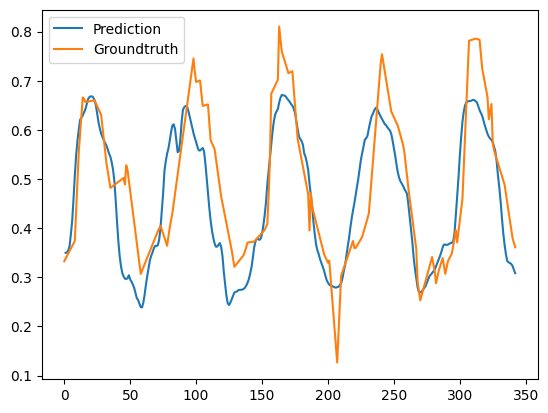

In [62]:
# Visualise prediction for a random pixel

random_pixel = (rd.randint(0,predictions.shape[1]-1), rd.randint(0,predictions.shape[1]-1))
band = 6
print(f'Band {band}')

plt.plot([k+1 for k in range(predictions.shape[0])], predictions[:,random_pixel[0],random_pixel[1],band], label='Prediction')
plt.plot(np.where(mask_test==1)[0], data_test_small[:,random_pixel[0],random_pixel[1],band][mask_test==1], label='Groundtruth')
plt.legend()

In [47]:
# Select one of the paths to get the corresponding results
trained_models_path = 'Sentinel2TS/Benchmark/WithOrth/' # Models trained with orthogonality loss
trained_models_path = 'Sentinel2TS/Benchmark/WithoutOrth/' # Models trained without orthogonality loss

nb_seeds = 5
MSE_extra_list = np.zeros(nb_seeds)
time_span = 341
initial_time = 0
for seed in range(nb_seeds):
  print(f"Seed number {seed}")
  predictions = torch.zeros(time_span+1,data_test_small.shape[1],data_test_small.shape[2],20, device='cpu')
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  for batch in range(data_test_small.shape[1]) :
    model.eval()
    input = initial_state_total[batch]
    xt, phis = model.forward_n_remember(input, time_span)
    prediction = model.decode(phis).cpu().detach()
    predictions[:,batch,:,:] = prediction
  MSE = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[mask_test[initial_time+1:]==1] **2)
  MSE_intra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[:-100][mask_test[initial_time+1:-100]==1] **2)
  MSE_extra = torch.mean((torch.Tensor(data_test_small[initial_time+1:]) - predictions[:,:,:,:10])[-100:][mask_test[-100:]==1] **2)
  print(f"Global MSE : {MSE}")
  print(f"MSE on training period : {MSE_intra}")
  print(f"MSE on validation period : {MSE_extra}")
  MSE_extra_list[seed] = MSE_extra
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_extra_list)} +- {np.std(MSE_extra_list)}")

Seed number 0
Global MSE : 0.00952081847935915
MSE on training period : 0.00835574883967638
MSE on validation period : 0.01185095775872469
Seed number 1
Global MSE : 0.00999391172081232
MSE on training period : 0.008711237460374832
MSE on validation period : 0.012559257447719574
Seed number 2
Global MSE : 0.009019102901220322
MSE on training period : 0.00819737371057272
MSE on validation period : 0.010662563145160675
Seed number 3
Global MSE : 0.010501950979232788
MSE on training period : 0.00936303660273552
MSE on validation period : 0.0127797806635499
Seed number 4
Global MSE : 0.009911551140248775
MSE on training period : 0.008637205697596073
MSE on validation period : 0.012460245750844479
Mean and standard deviation of extrapolation MSE over 5 seeds: 0.012062560953199863 +- 0.0007647266823234335


With orthogonality -> 0.010346420854330064 +- 0.0009714148386763294

Without orthogonality -> 0.012062560953199863 +- 0.0007647266823234335

## Assimilation-forecasting on Fontainebleau

In [ ]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

# Select one of the paths to get the corresponding results
#trained_models_path = 'Sentinel2TS/Benchmark/WithOrth/' # Models trained with orthogonality loss
trained_models_path = 'Sentinel2TS/Benchmark/WithoutOrth/' # Models trained without orthogonality loss
nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  initial_latent_state = model.encode(initial_state_total)
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state]
    for k in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis).permute((3,1,2,0))
    loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,1:time_span+2])
    loss.backward()
    opt.step()
    if epoch % 10 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")

  phis = [initial_latent_state]
  for k in range(predictions.shape[-1]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  decoded = model.decode(phis).permute((3,1,2,0))
  predictions[:,:,:,:] = decoded
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed number 0
Epoch 0 : loss 2637.06298828125
Epoch 10 : loss 531.2542114257812
Epoch 20 : loss 387.90313720703125
Epoch 30 : loss 329.7782287597656
Epoch 40 : loss 302.15765380859375
Epoch 50 : loss 287.8586120605469
Epoch 60 : loss 279.9645690917969
Epoch 70 : loss 275.30615234375
Epoch 80 : loss 272.3539733886719
Epoch 90 : loss 270.3575744628906
Epoch 100 : loss 268.9205017089844
Epoch 110 : loss 267.84039306640625
Epoch 120 : loss 267.00311279296875
Epoch 130 : loss 266.32489013671875
Epoch 140 : loss 265.7740783691406
Epoch 150 : loss 265.3182373046875
Epoch 160 : loss 264.93658447265625
Epoch 170 : loss 264.6019592285156
Epoch 180 : loss 264.3197021484375
Epoch 190 : loss 264.083251953125
Epoch 200 : loss 263.8777160644531
Final test MSE : 0.001303899916820228
Seed number 1
Epoch 0 : loss 2666.421142578125
Epoch 10 : loss 565.2330322265625
Epoch 20 : loss 412.6427917480469
Epoch 30 : loss 348.9095764160156
Epoch 40 : loss 317.2919921875
Epoch 50 : loss 301.3645935058594
Epoch 60

With orthogonality -> 0.0011231523938477039 +- 3.934472030482031e-05

Without orthogonality -> 0.0012256060959771275 +- 9.931004946480478e-05

## Assimilation-forecasting on Orléans

In [ ]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

# Here we run the models with orthogonality with the best optimization hyperparameters
trained_models_path = 'Sentinel2TS/Benchmark/WithOrth/' # Models trained with orthogonality loss
nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  initial_latent_state = model.encode(initial_state_total)
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()
  epochs = 101
  opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state]
    for k in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1]).permute((3,1,2,0))
    loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 10 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")

  phis = [initial_latent_state]
  for k in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions = model.decode(phis).permute((3,1,2,0))
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed number 0
Epoch 0 : loss 5067.875
Epoch 10 : loss 1606.941650390625
Epoch 20 : loss 1278.9996337890625
Epoch 30 : loss 1120.3992919921875
Epoch 40 : loss 1032.385986328125
Epoch 50 : loss 980.0573120117188
Epoch 60 : loss 946.3264770507812
Epoch 70 : loss 923.17041015625
Epoch 80 : loss 906.5154418945312
Epoch 90 : loss 893.9240112304688
Epoch 100 : loss 884.1419067382812
torch.Size([20, 100, 100, 343]) torch.Size([10, 100, 100, 343])
Final test MSE : 0.0032873249147087336
Seed number 1
Epoch 0 : loss 5974.46875
Epoch 10 : loss 1671.5181884765625
Epoch 20 : loss 1321.5673828125
Epoch 30 : loss 1150.8773193359375
Epoch 40 : loss 1058.849365234375
Epoch 50 : loss 1003.5797119140625
Epoch 60 : loss 967.7286987304688
Epoch 70 : loss 943.0765991210938
Epoch 80 : loss 925.3536987304688
Epoch 90 : loss 911.9572143554688
Epoch 100 : loss 901.5115356445312
torch.Size([20, 100, 100, 343]) torch.Size([10, 100, 100, 343])
Final test MSE : 0.003611621679738164
Seed number 2
Epoch 0 : loss 5192.

In [ ]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

# Now we run the models without orthogonality with their best optimization hyperparameters
trained_models_path = 'Sentinel2TS/Benchmark/WithoutOrth/' # Models trained with orthogonality loss
nb_seeds = 5
MSE_list = np.zeros(nb_seeds)
for seed in range(nb_seeds):
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  initial_latent_state = model.encode(initial_state_total)
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=2e-3)
  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state]
    for k in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1]).permute((3,1,2,0))
    loss = model.mse_loss(decoded[:10], reflectances_cuda[:,:,:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 10 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")

  phis = [initial_latent_state]
  for k in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions = model.decode(phis).permute((3,1,2,0))
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")

Seed number 0
Epoch 0 : loss 5601.5751953125
Epoch 10 : loss 1700.4976806640625
Epoch 20 : loss 1421.4112548828125
Epoch 30 : loss 1262.0982666015625
Epoch 40 : loss 1177.689453125
Epoch 50 : loss 1127.4381103515625
Epoch 60 : loss 1095.1907958984375
Epoch 70 : loss 1073.732666015625
Epoch 80 : loss 1058.6614990234375
Epoch 90 : loss 1047.7310791015625
Epoch 100 : loss 1039.244140625
Epoch 110 : loss 1032.466064453125
Epoch 120 : loss 1027.1302490234375
Epoch 130 : loss 1022.67578125
Epoch 140 : loss 1018.9482421875
Epoch 150 : loss 1015.7423706054688
Epoch 160 : loss 1012.9548950195312
Epoch 170 : loss 1010.5531616210938
Epoch 180 : loss 1008.5341796875
Epoch 190 : loss 1006.7648315429688
Epoch 200 : loss 1005.1954345703125
torch.Size([20, 100, 100, 343]) torch.Size([10, 100, 100, 343])
Final test MSE : 0.003848504275083542
Seed number 1
Epoch 0 : loss 5655.93017578125
Epoch 10 : loss 1692.5992431640625
Epoch 20 : loss 1371.7503662109375
Epoch 30 : loss 1211.578369140625
Epoch 40 : lo

Expected result -> 0.004270057054236531 +- 0.0005532479592660944